# Split-Belt Data Set 

## Cleaning and Validation

This notebook is dedicated to **Cleaning** and **Validating** the the split-belt dataset.

**Methods**
- Remove data that is missing essential parameters
- Removing data that has been misentered
    - Ages less than 18
    - Speed Ratios that are not integers (i.e., 2 or 3)
- Correct Units
    - Specifically height and weight were converted to cm and kg, respectively
- Generate new parameters
    - Descritize targets that we wish to classify
    - BMI
    - Categorical Young variable
- Finaly, updated data is saved

Import Data
---

In [1]:
import pandas as pd

df = pd.read_csv("DataBase_Draft_12_28_2020_First.csv", engine='python')
df = df.drop(columns=['Lab', 'Institution', 'ID'])
df.head()

,Publication,GroupNum,Height,Weight,Age,Male,RightLeg_Dom,RightLeg_Fast,AdaptationDuration,Abrupt,...,Stroke,TextSpeedRatio,BaseSTD,Naive,TMAEFirst,EntityID,EventDetection,AdaptationDurationMins,TMBaseMid,Clinical
0,NaN,1,160.0,60.9,20.0,0.0,1.0,1.0,604.0,1.0,...,0.0,2.0,0.016029,1.0,1.0,517.0,NaN,NaN,1.0,0.0
1,NaN,1,183.5,70.5,22.0,1.0,1.0,1.0,602.0,1.0,...,0.0,2.0,0.023901,1.0,1.0,518.0,NaN,NaN,1.0,0.0
2,NaN,1,174.0,68.0,20.0,0.0,1.0,1.0,602.0,1.0,...,0.0,2.0,0.020686,1.0,1.0,515.0,NaN,NaN,1.0,0.0
3,NaN,1,159.0,59.2,20.0,1.0,1.0,1.0,603.0,1.0,...,0.0,2.0,0.017556,1.0,1.0,519.0,NaN,NaN,1.0,0.0
4,NaN,1,160.0,60.9,20.0,0.0,1.0,1.0,601.0,1.0,...,0.0,2.0,0.013288,0.0,1.0,517.0,NaN,NaN,1.0,0.0


In [2]:
# set random seed to increase repeatability
import numpy as np
RSEED=50
np.random.seed(RSEED)

Plotting Functions
---

In [3]:
import matplotlib.pyplot as plt  # To visualize
import seaborn as sns # Also to visualize
import math #rounding up

In [4]:
def InitialVisualization(Inputs, DataFrame):
    nrows=math.ceil(len(Inputs)/5)
    plt.figure(figsize=(10, 2*nrows))
    for i in range(len(Inputs)):
        plt.subplot(nrows, 5, i+1)
        if len(DataFrame[Inputs[i]].unique())<=5:
            sns.countplot(x=Inputs[i], data=DataFrame)
        else:
            hist = DataFrame.boxplot(column=Inputs[i])
    plt.tight_layout()
    plt.show()

# Data For Exclusion

I am going to create a copy of the data (df) in order to impliment the clearning. The 'cleaned' data is what I suggest for future analysis.

In [5]:
# Make a COPY of my data for cleaning
dfClean=df.copy()

I am only including split-belt sessions that include an assessment of baseline walking and an assessment of split-belt After-Effects on the treadmill (i.e., locomotor recalibration).

While other metrics have missing data, this data will be filled rather than excluded.

In [6]:
badIndex = ( (np.isnan(df.TMBase)==True) | (np.isnan(df.TMBase)==True) )
dfClean = dfClean.drop(dfClean[badIndex].index)
dfClean.shape

(704, 35)

# Kinematic Validation

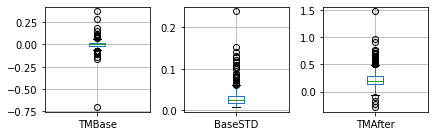

In [7]:
InitialVisualization(["TMBase", "BaseSTD", "TMAfter"], dfClean)

/Users/carlysombric/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/carlysombric/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/carlysombric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


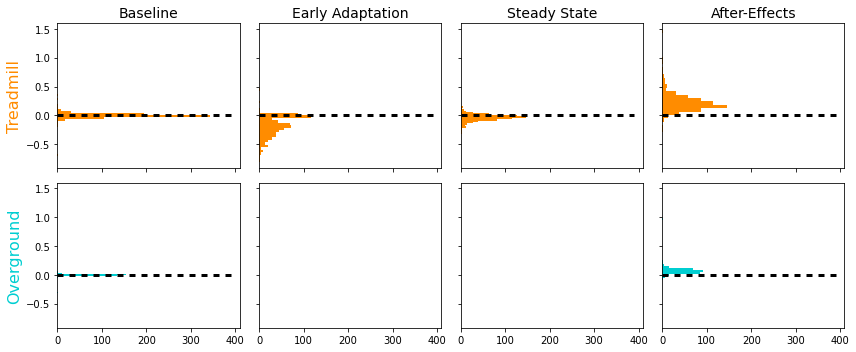

In [8]:
#plt.figure(figsize=(10, 12), sharey=True)
fig, axs = plt.subplots(2, 4, sharey=True, sharex=True, tight_layout=True, figsize=(12,5))

axs[0, 0].hist(dfClean.TMBase, orientation='horizontal', bins=30, color='darkorange')
axs[0, 0].set_ylabel('Treadmill', FontSize=16, color='darkorange')
axs[0, 0].set_title('Baseline', FontSize=14)
axs[0, 0].plot([0, 390], [0, 0], 'k-', lw=3,dashes=[2, 2])

axs[0, 1].hist(dfClean.EarlyA, orientation='horizontal', bins=30, color='darkorange')
axs[0, 1].set_title('Early Adaptation', FontSize=14)
axs[0, 1].plot([0, 390], [0, 0], 'k-', lw=3,dashes=[2, 2])

axs[0, 2].hist(dfClean.TMSteady, orientation='horizontal', bins=30, color='darkorange')
axs[0, 2].set_title('Steady State', FontSize=14)
axs[0, 2].plot([0, 390], [0, 0], 'k-', lw=3,dashes=[2, 2])

axs[0, 3].hist(dfClean.TMAfter, orientation='horizontal', bins=30, color='darkorange')
axs[0, 3].set_title('After-Effects', FontSize=14)
axs[0, 3].plot([0, 390], [0, 0], 'k-', lw=3,dashes=[2, 2])

axs[1, 0].hist(dfClean.OGBase, orientation='horizontal', bins=30, color='darkturquoise')
axs[1, 0].set_ylabel('Overground', FontSize=16, color='darkturquoise')
axs[1, 0].plot([0, 390], [0, 0], 'k-', lw=3,dashes=[2, 2])

axs[1, 3].hist(dfClean.OGAfter, orientation='horizontal', bins=30, color='darkturquoise')
axs[1, 3].plot([0, 390], [0, 0], 'k-', lw=3,dashes=[2, 2])

plt.savefig('EpochValidation.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)    
   
fig.show()

### Discretizeing Age

Given that 0.04 is a clinically signfiicant change in step length asymmetry (Patterson et al. 2008) this threshold will be used to descritize subjects with "successful" verses "poor" locomotor recalibration. Specifically, I am framing this analysis as a classification problem endeavouring to identify those that will have clincially significant gait changes from split-belt adaptation. Thus treadmill After-Effects greater than or equal to 0.04 will indicated "successful" locmotor recalibration.

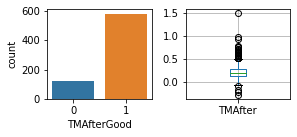

In [9]:
# Threshold from Patterson 2008
dfClean["TMAfterGood"]=1*(dfClean["TMAfter"]> 0.04)
dfClean["TMAfterBad"]=1*(dfClean["TMAfter"]<= 0.04)
InitialVisualization(["TMAfterGood", "TMAfter"], dfClean)

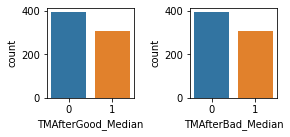

In [10]:
# Using median behavior as the threshold
MedianTMAfter = dfClean['TMAfter'].median()
dfClean["TMAfterGood_Median"]=1*(dfClean["TMAfter"]> MedianTMAfter)
dfClean["TMAfterBad_Median"]=1*(dfClean["TMAfter"]<= MedianTMAfter)
InitialVisualization(["TMAfterGood_Median", "TMAfterBad_Median"], dfClean)

# Protocol Validation

The duration of adaptaiton is measured in minutes or strides. In order to justify these two units, I am **estimating** that people average 50 strides a minute.

In [11]:
OnlyDurationInMins = dfClean.loc[( (np.isnan(dfClean.AdaptationDuration)==True) & (np.isnan(dfClean.AdaptationDurationMins)==False) ),'AdaptationDuration'].index
dfClean.at[OnlyDurationInMins,"AdaptationDuration"] = 50 * dfClean.loc[OnlyDurationInMins,'AdaptationDurationMins']

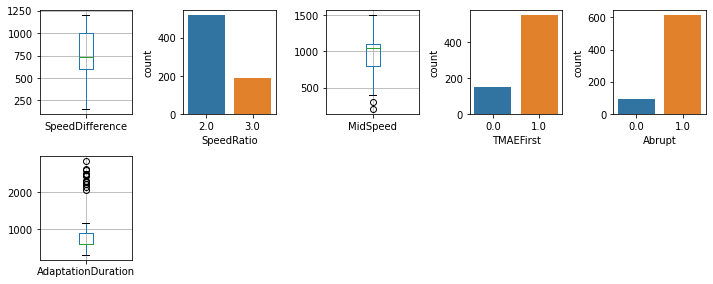

In [12]:
InitialVisualization(["SpeedDifference", "SpeedRatio", "MidSpeed", 'TMAEFirst', "Abrupt", "AdaptationDuration"], dfClean)

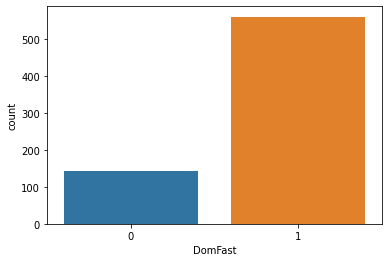

In [13]:
# I do not think we are using this for anything
dfClean["DomFast"] = 1*(dfClean["RightLeg_Dom"] == dfClean["RightLeg_Fast"])

sns.countplot(x="DomFast", data=dfClean)
plt.show()

In [14]:
# Shouldn't need to do this anymore because getting rid of places where not the case?
WhereToZero = dfClean.loc[(dfClean['TMAEFirst']!=0) & (dfClean['TMAEFirst']!=1),'TMAEFirst'].index
dfClean.at[WhereToZero,'TMAEFirst'] = 0
dfClean['TMAEFirst'].unique()

array([1., 0.])

# Subject Demographics


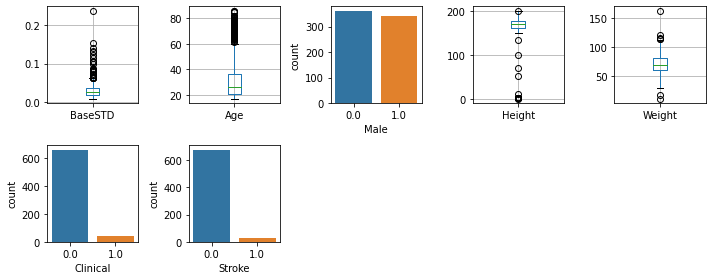

In [15]:
InitialVisualization(["BaseSTD", "Age", "Male", "Height", "Weight", 'Clinical', 'Stroke'], dfClean)

### Cleaning Height & Weight and Calculating BMI

Based on the initial visualization of height and weight it is clear that there are some issues with height and weight.  First, there are missing values, second some values seem to be in the wrong units (recall that height should be in cm and weight should be in kg) or are otherwise not realistic.  The current strategy is to correct units, replace unrealistic values with mean, and then calculate BMI.

In [16]:
# Clearn Weights

# Calculate what the mean resonable height is
NormalWeight = dfClean.loc[dfClean["Weight"]>30,'Height'].index
NormalWeightMean = dfClean.loc[NormalWeight,'Weight'].mean()

# Replace unresonable weights with the mean
WrongWeight = dfClean.loc[dfClean["Weight"]<30,'Weight'].index
dfClean.at[WrongWeight,'Weight'] = NormalWeightMean


In [17]:
#Clean Heights

# Convert Heights presumed in meters to centimeters for consistency
MeterHeight = dfClean.loc[dfClean["Height"]<2,'Height'].index
dfClean.at[MeterHeight,'Height'] = 100 * dfClean.loc[dfClean["Height"]<2, "Height"]

# Calculate what the mean resonable height is
NormalHeight = dfClean.loc[dfClean["Height"]>122,'Height'].index
NormalHeightMean = dfClean.loc[NormalHeight,'Height'].mean()

# Replace unresonable heights with the mean
WrongHeight = dfClean.loc[dfClean["Height"]<122,'Height'].index
dfClean.at[WrongHeight,'Height'] = NormalHeightMean


In [18]:
# Fill missing heights and weights 
dfClean["Height"] = dfClean["Height"].fillna(dfClean["Height"].mean())
dfClean["Weight"] = dfClean["Weight"].fillna(dfClean["Weight"].mean())

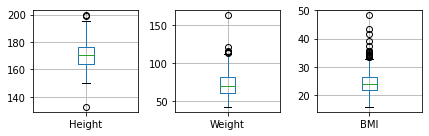

In [19]:
# Finally, calculate BMI
dfClean["BMI"] = (dfClean["Weight"]/(dfClean["Height"]/100)**2)
InitialVisualization(["Height", "Weight", "BMI"], dfClean)

### Discretizeing Age

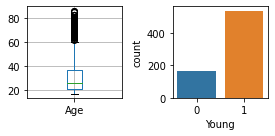

In [20]:
dfClean["Young"]=1*(dfClean["Age"]<40)

InitialVisualization(["Age", "Young"], dfClean)

Save Cleaned Data
---

In [21]:
dfSQL = pd.DataFrame(columns=['entity_id'])
dfSQL["entity_id"] = dfClean["EntityID"]

dfSQL["entity_id"].isnull().values.any()
dfSQL["entity_id"].isnull().sum()
MissingEntitiyID_Index = dfSQL[dfSQL["entity_id"].isnull()].index.tolist()

for i in range(len(MissingEntitiyID_Index)):
    dfSQL.loc[MissingEntitiyID_Index[i], "entity_id"] = i+3000
    
    
dfSQL["entity_id"].isnull().values.any()

#dfSQL[MissingEntitiyID_Index[i], "entity_id"]#
dfSQL["entity_id"] = dfSQL["entity_id"].astype(int)

In [22]:
dfSQL["event_id"] = range(1, len(dfSQL.index)+1)

In [23]:
import datetime
import random

listDates = ["01/01/1920", "01/01/1919", "01/01/1918", "01/01/1917", "01/01/1916"]

dfSQL["date"] = random.choices(listDates, k=len(dfClean.index))

dfSQL["date"]= pd.to_datetime(dfSQL["date"]) 

In [24]:
dfSQL["speed_ratio"] = dfClean["SpeedRatio"]
dfSQL["speed_diff"] = dfClean["SpeedDifference"]
dfSQL["mid_speed"] = dfClean["MidSpeed"]
dfSQL["abrupt"] = dfClean["Abrupt"]
dfSQL["base"] = dfClean["TMBase"]
dfSQL["duration"] = dfClean["AdaptationDuration"]
dfSQL["age"] = dfClean["Age"]
dfSQL["young"] = dfClean["Young"]
dfSQL["height"] = dfClean["Height"]
dfSQL["weight"] = dfClean["Weight"]
dfSQL["bmi"] = dfClean["BMI"]
dfSQL["catch"] = dfClean["IsCatch"]
dfSQL["clinical"] = dfClean["Clinical"]
dfSQL["male"] = dfClean["Male"]
dfSQL["tmfirst"] = dfClean['TMAEFirst']
dfSQL["basestd"] = dfClean['BaseSTD']
dfSQL["AE"] = dfClean["TMAfterBad"]
dfSQL["AEgood"] = dfClean["TMAfterGood"]
dfSQL["AE_Median"] = dfClean["TMAfterBad_Median"]
dfSQL["AEgood_Median"] = dfClean["TMAfterGood_Median"]

In [25]:
dfSQL.to_csv('SQLDataBase.csv', index=False)